Birkan Cemil Abacı 
20070001048

# Bottleneck Residual Block and ResNet Implementation

A bottleneck residual block in ResNet is designed to reduce the number of parameters and computational cost while maintaining the performance. It consists of three convolutional layers with a residual connection:


## Bottleneck Residual Block Design

The bottleneck residual block consists of the following components:
- Convolutional layers
- ReLU activation function
- Batch normalization
- Residual connection

The general structure of the bottleneck residual block is as follows:
1. 1x1 Convolution (Bottleneck), BatchNorm, ReLU
2. 3x3 Convolution, BatchNorm, ReLU
3. 1x1 Convolution, BatchNorm
4. Residual connection (shortcut connection)
5. Final ReLU activation

### Visual Representation

The following image illustrates the structure of the bottleneck residual block:
> https://medium.com/@neetu.sigger/a-comprehensive-guide-to-understanding-and-implementing-bottleneck-residual-blocks-6b420706f66b
![Bottleneck Residual Block](1_yyCzdQ2hZIQN9zv3Ta917Q.webp)




In [1]:
!pip install torchinfo==0.0.1

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import time
from torchinfo import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and prepare the dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
trn_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
vld_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
tst_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the training set into training and validation partitions
trn_size = int(0.8 * len(trn_dataset))
vld_size = len(trn_dataset) - trn_size
torch.manual_seed(0)
trn_dataset, vld_dataset = random_split(trn_dataset, [trn_size, vld_size])

classes = 'Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck'
num_classes = len(classes)
batch_size = 32
trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
vld_loader = DataLoader(vld_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
tst_loader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 50353849.72it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Define the CNN Model with Bottleneck Residual Blocks
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * 4
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

model = ResNet(Bottleneck, [3, 4, 6, 3]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

num_epochs = 11
best_model_wts = model.state_dict()
best_acc = 0.0

train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # validation
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # training
            dataloader = trn_loader
        else:
            model.eval()  # evaluate
            dataloader = vld_loader

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        if phase == 'train':
            train_loss_history.append(epoch_loss)
        else:
            val_loss_history.append(epoch_loss)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()
            torch.save(model.state_dict(), 'best_model.pth')

print('Best val Acc: {:4f}'.format(best_acc))

# Load best model weights
model.load_state_dict(torch.load('best_model.pth'))


Epoch 0/10
----------
train Loss: 1.8759 Acc: 0.3149
val Loss: 1.6245 Acc: 0.4431
Epoch 1/10
----------
train Loss: 1.3643 Acc: 0.5017
val Loss: 1.4296 Acc: 0.5338
Epoch 2/10
----------
train Loss: 1.0991 Acc: 0.6050
val Loss: 0.9941 Acc: 0.6475
Epoch 3/10
----------
train Loss: 0.9081 Acc: 0.6772
val Loss: 1.5156 Acc: 0.6642
Epoch 4/10
----------
train Loss: 0.7670 Acc: 0.7316
val Loss: 2.2248 Acc: 0.6784
Epoch 5/10
----------
train Loss: 0.6481 Acc: 0.7728
val Loss: 0.8623 Acc: 0.7586
Epoch 6/10
----------
train Loss: 0.5551 Acc: 0.8064
val Loss: 1.0508 Acc: 0.7290
Epoch 7/10
----------
train Loss: 0.4688 Acc: 0.8351
val Loss: 1.2917 Acc: 0.7754
Epoch 8/10
----------
train Loss: 0.4013 Acc: 0.8603
val Loss: 0.8653 Acc: 0.7853
Epoch 9/10
----------
train Loss: 0.3385 Acc: 0.8832
val Loss: 0.7587 Acc: 0.7721
Epoch 10/10
----------
train Loss: 0.2823 Acc: 0.9017
val Loss: 1.7038 Acc: 0.7487
Best val Acc: 0.785300


<All keys matched successfully>

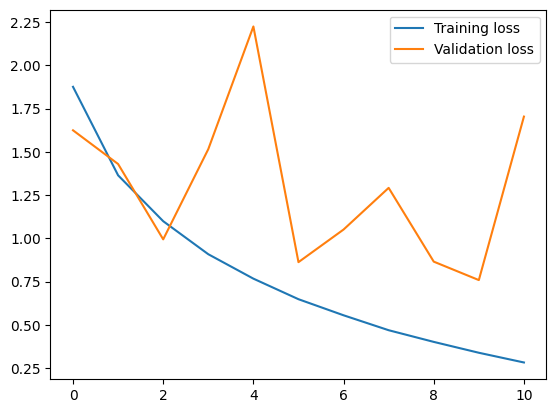

Accuracy of the network on the 10000 test images: 78.53 %


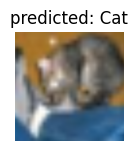

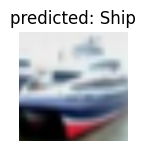

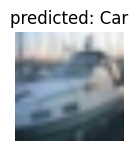

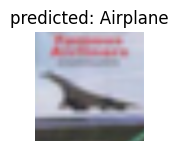

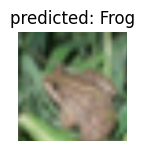

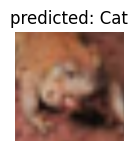

In [11]:
# Eğitim ve doğrulama kayıplarını çizmek
plt.figure()
plt.plot(train_loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.legend()
plt.show()

# Modelin tahmin doğruluğunu değerlendirmek
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in tst_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

# Görüntüleri ve tahminleri görselleştirmek
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

#FROM TOP THE imshow function is from chatgpt.

def visualize_model_predictions(model, loader=tst_loader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: ' + classes[preds[j]])
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    model.train(mode=was_training)

visualize_model_predictions(model, tst_loader)

> - What I see here is that the validation fluctuates but according to what I searched on the internet it always decreases as the number of epochs increases, I found that the fluctuation is normal


***Q2***

Epoch 0/10
----------
train Loss: 1.2417 Acc: 0.5555
val Loss: 1.0337 Acc: 0.6365
Epoch 1/10
----------
train Loss: 0.9344 Acc: 0.6696
val Loss: 1.0991 Acc: 0.6424
Epoch 2/10
----------
train Loss: 0.8068 Acc: 0.7183
val Loss: 1.0137 Acc: 0.6645
Epoch 3/10
----------
train Loss: 0.7245 Acc: 0.7477
val Loss: 0.6612 Acc: 0.7686
Epoch 4/10
----------
train Loss: 0.6504 Acc: 0.7747
val Loss: 0.6753 Acc: 0.7628
Epoch 5/10
----------
train Loss: 0.5950 Acc: 0.7940
val Loss: 0.5979 Acc: 0.7896
Epoch 6/10
----------
train Loss: 0.5422 Acc: 0.8120
val Loss: 0.6172 Acc: 0.7857
Epoch 7/10
----------
train Loss: 0.5016 Acc: 0.8267
val Loss: 0.5916 Acc: 0.7992
Epoch 8/10
----------
train Loss: 0.4644 Acc: 0.8375
val Loss: 0.6044 Acc: 0.7947
Epoch 9/10
----------
train Loss: 0.4266 Acc: 0.8497
val Loss: 0.6499 Acc: 0.7821
Epoch 10/10
----------
train Loss: 0.3943 Acc: 0.8625
val Loss: 0.6131 Acc: 0.7919
Best val Acc: 0.799200


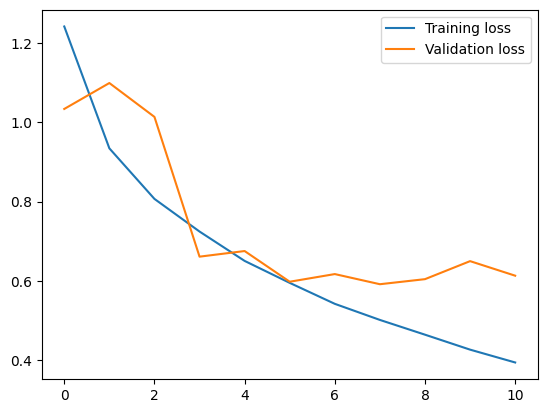

In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
num_epochs = 11
best_model_wts = model.state_dict()
best_acc = 0.0

train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  
            dataloader = trn_loader
        else:
            model.eval() 
            dataloader = vld_loader

        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        if phase == 'train':
            train_loss_history.append(epoch_loss)
        else:
            val_loss_history.append(epoch_loss)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()
            torch.save(model.state_dict(), 'best_model_adam.pth')

print('Best val Acc: {:4f}'.format(best_acc))

model.load_state_dict(torch.load('best_model_adam.pth'))

# Plot learning and generalization curves taken from gpt.
plt.figure()
plt.plot(train_loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.legend()
plt.show()

***Q2 b***


Epoch 0/10
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


train Loss: 0.4607 Acc: 0.8393
val Loss: 0.5746 Acc: 0.8019
Current learning rate: 0.001
Epoch 1/10
----------
train Loss: 0.4202 Acc: 0.8537
val Loss: 0.6295 Acc: 0.7847
Current learning rate: 0.001
Epoch 2/10
----------
train Loss: 0.3899 Acc: 0.8639
val Loss: 0.5723 Acc: 0.8086
Current learning rate: 0.001
Epoch 3/10
----------
train Loss: 0.3650 Acc: 0.8737
val Loss: 0.5321 Acc: 0.8214
Current learning rate: 0.001
Epoch 4/10
----------
train Loss: 0.3353 Acc: 0.8843
val Loss: 0.5808 Acc: 0.8084
Current learning rate: 0.001
Epoch 5/10
----------
train Loss: 0.3068 Acc: 0.8946
val Loss: 0.5634 Acc: 0.8196
Current learning rate: 0.001
Epoch 6/10
----------
train Loss: 0.2908 Acc: 0.8980
val Loss: 0.5616 Acc: 0.8147
Current learning rate: 0.0001
Epoch 7/10
----------
train Loss: 0.1404 Acc: 0.9573
val Loss: 0.4748 Acc: 0.8457
Current learning rate: 0.0001
Epoch 8/10
----------
train Loss: 0.0876 Acc: 0.9759
val Loss: 0.4940 Acc: 0.8442
Current learning rate: 0.0001
Epoch 9/10
---------

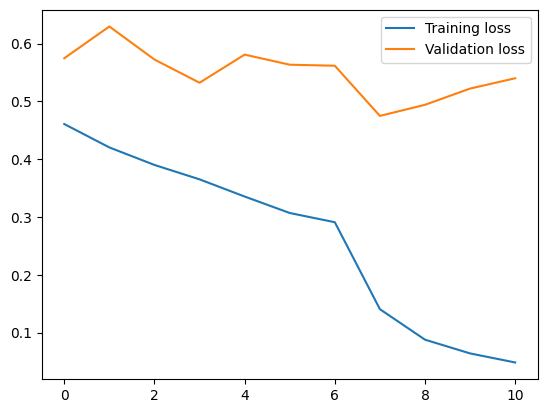

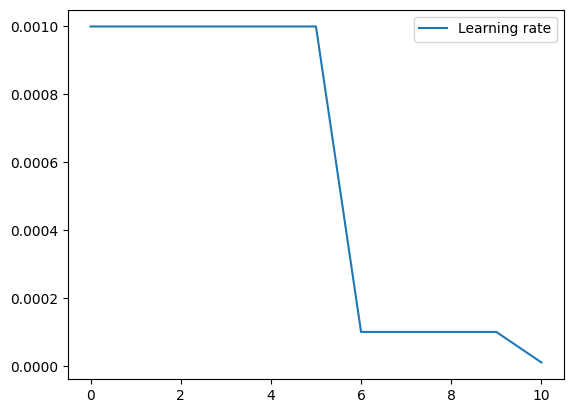

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

num_epochs = 11
best_model_wts = model.state_dict()
best_acc = 0.0

train_loss_history = []
val_loss_history = []
learning_rates = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = trn_loader
        else:
            model.eval()
            dataloader = vld_loader

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        if phase == 'train':
            train_loss_history.append(epoch_loss)
        else:
            val_loss_history.append(epoch_loss)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val':
            scheduler.step(epoch_loss)

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()
            torch.save(model.state_dict(), 'best_model_adam_scheduler.pth')

    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    print(f'Current learning rate: {current_lr}')

print('Best val Acc: {:4f}'.format(best_acc))

# Load best model weights
model.load_state_dict(torch.load('best_model_adam_scheduler.pth'))

# Plot learning and generalization curves taken from gpt
plt.figure()
plt.plot(train_loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(learning_rates, label='Learning rate')
plt.legend()
plt.show()


***Q3***

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


Epoch 0/9
----------
train Loss: 0.9274 Acc: 0.7037
val Loss: 0.7083 Acc: 0.7636
Epoch 1/9
----------
train Loss: 0.6851 Acc: 0.7696
val Loss: 0.6580 Acc: 0.7746
Epoch 2/9
----------
train Loss: 0.6385 Acc: 0.7816
val Loss: 0.6405 Acc: 0.7797
Epoch 3/9
----------
train Loss: 0.6204 Acc: 0.7874
val Loss: 0.6251 Acc: 0.7864
Epoch 4/9
----------
train Loss: 0.6055 Acc: 0.7921
val Loss: 0.6192 Acc: 0.7856
Epoch 5/9
----------
train Loss: 0.5890 Acc: 0.7954
val Loss: 0.6129 Acc: 0.7906
Epoch 6/9
----------
train Loss: 0.5783 Acc: 0.8016
val Loss: 0.6156 Acc: 0.7862
Epoch 7/9
----------
train Loss: 0.5730 Acc: 0.8033
val Loss: 0.6231 Acc: 0.7871
Epoch 8/9
----------
train Loss: 0.5634 Acc: 0.8080
val Loss: 0.6091 Acc: 0.7890
Epoch 9/9
----------
train Loss: 0.5493 Acc: 0.8115
val Loss: 0.6021 Acc: 0.7912
Best val Acc: 0.791200


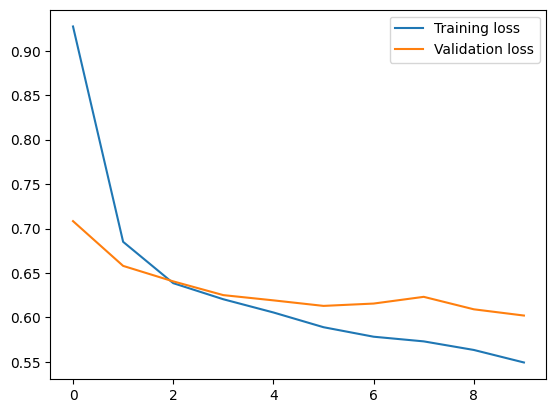

Accuracy of the network on the 10000 test images: 79.5 %


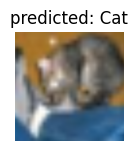

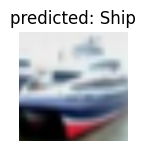

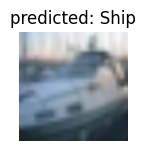

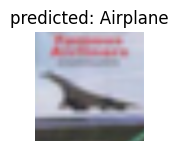

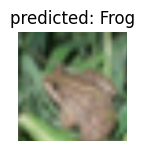

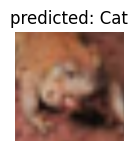

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and prepare the dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
trn_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
vld_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
tst_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the training set into training and validation partitions
trn_size = int(0.8 * len(trn_dataset))
vld_size = len(trn_dataset) - trn_size
torch.manual_seed(0)
trn_dataset, vld_dataset = random_split(trn_dataset, [trn_size, vld_size])

classes = 'Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck'
num_classes = len(classes)
batch_size = 128
trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
vld_loader = DataLoader(vld_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
tst_loader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# replace last fc layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

num_epochs = 10
best_model_wts = model.state_dict()
best_acc = 0.0

train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  
            dataloader = trn_loader
        else:
            model.eval()  
            dataloader = vld_loader

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        if phase == 'train':
            train_loss_history.append(epoch_loss)
        else:
            val_loss_history.append(epoch_loss)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()
            torch.save(model.state_dict(), 'best_model_transfer.pth')

print('Best val Acc: {:4f}'.format(best_acc))

model.load_state_dict(torch.load('best_model_transfer.pth'))

plt.figure()
plt.plot(train_loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.legend()
plt.show()

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in tst_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

def visualize_model_predictions(model, loader=tst_loader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: ' + classes[preds[j]])
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    model.train(mode=was_training)

visualize_model_predictions(model, tst_loader)


**Results**
- In this project, I built a classification model using transfer learning on the CIFAR-10 dataset. For this, I used the ResNet-50 model previously trained on ImageNet, modified the last layer of the ResNet-50 model according to the CIFAR-10 classes and trained only this layer. 
successfully performed classification on the CIFAR-10 dataset using the pre-trained ResNet-50 model and plot the accuracy of the model on the test dataset and the training and validation losses and accuracies obtained during the training process. These results show that transfer learning can perform strongly even on small datasets.

# **References**

- https://github.com/AlaaSedeeq/Residual-Blocks-Implementation
- https://medium.com/analytics-vidhya/understanding-resnet-architecture-869915cc2a98
- https://medium.com/@neetu.sigger/a-comprehensive-guide-to-understanding-and-implementing-bottleneck-residual-blocks-6b420706f66b
- https://towardsdatascience.com/creating-deeper-bottleneck-resnet-from-scratch-using-tensorflow-93e11ff7eb02
- for plotting -> chatGPT